In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import PIL

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split

%matplotlib inline

/Users/aleksey/anaconda3/envs/learning/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data preprocessing

In [2]:
df = pd.read_csv('./train.csv')
df = df.drop('PassengerId', 1)
df = df.drop('Name', 1)
df = df.drop('Ticket', 1)
df = df.drop('Cabin', 1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [3]:
encode_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
for enc in encode_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,0,0,1,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
1,1,38.0,71.2833,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,1,26.0,7.9250,0,0,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,1,35.0,53.1000,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,0,35.0,8.0500,0,0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1


In [4]:
df.describe()

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,32.204208,0.242424,0.206510,0.551066,0.352413,0.647587,0.682379,0.234568,...,0.760943,0.132435,0.089787,0.005612,0.004489,0.005612,0.001122,0.188552,0.086420,0.722783
std,0.486592,14.526497,49.693429,0.428790,0.405028,0.497665,0.477990,0.477990,0.465813,0.423966,...,0.426747,0.339154,0.286037,0.074743,0.066890,0.074743,0.033501,0.391372,0.281141,0.447876
min,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,28.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,38.000000,31.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,80.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
real_features = ['Age', 'Fare']
cat_features = list(set(df.columns.values.tolist()) - set(real_features) )
cat_features.remove('Survived')
print (cat_features)

['Parch_4', 'SibSp_5', 'Parch_5', 'Parch_1', 'Parch_2', 'SibSp_3', 'SibSp_4', 'Sex_female', 'Embarked_S', 'SibSp_8', 'SibSp_1', 'Embarked_Q', 'Pclass_1', 'Pclass_2', 'SibSp_2', 'Embarked_C', 'Sex_male', 'Parch_0', 'Parch_6', 'Pclass_3', 'SibSp_0', 'Parch_3']


In [6]:
print (df.shape)

(891, 25)


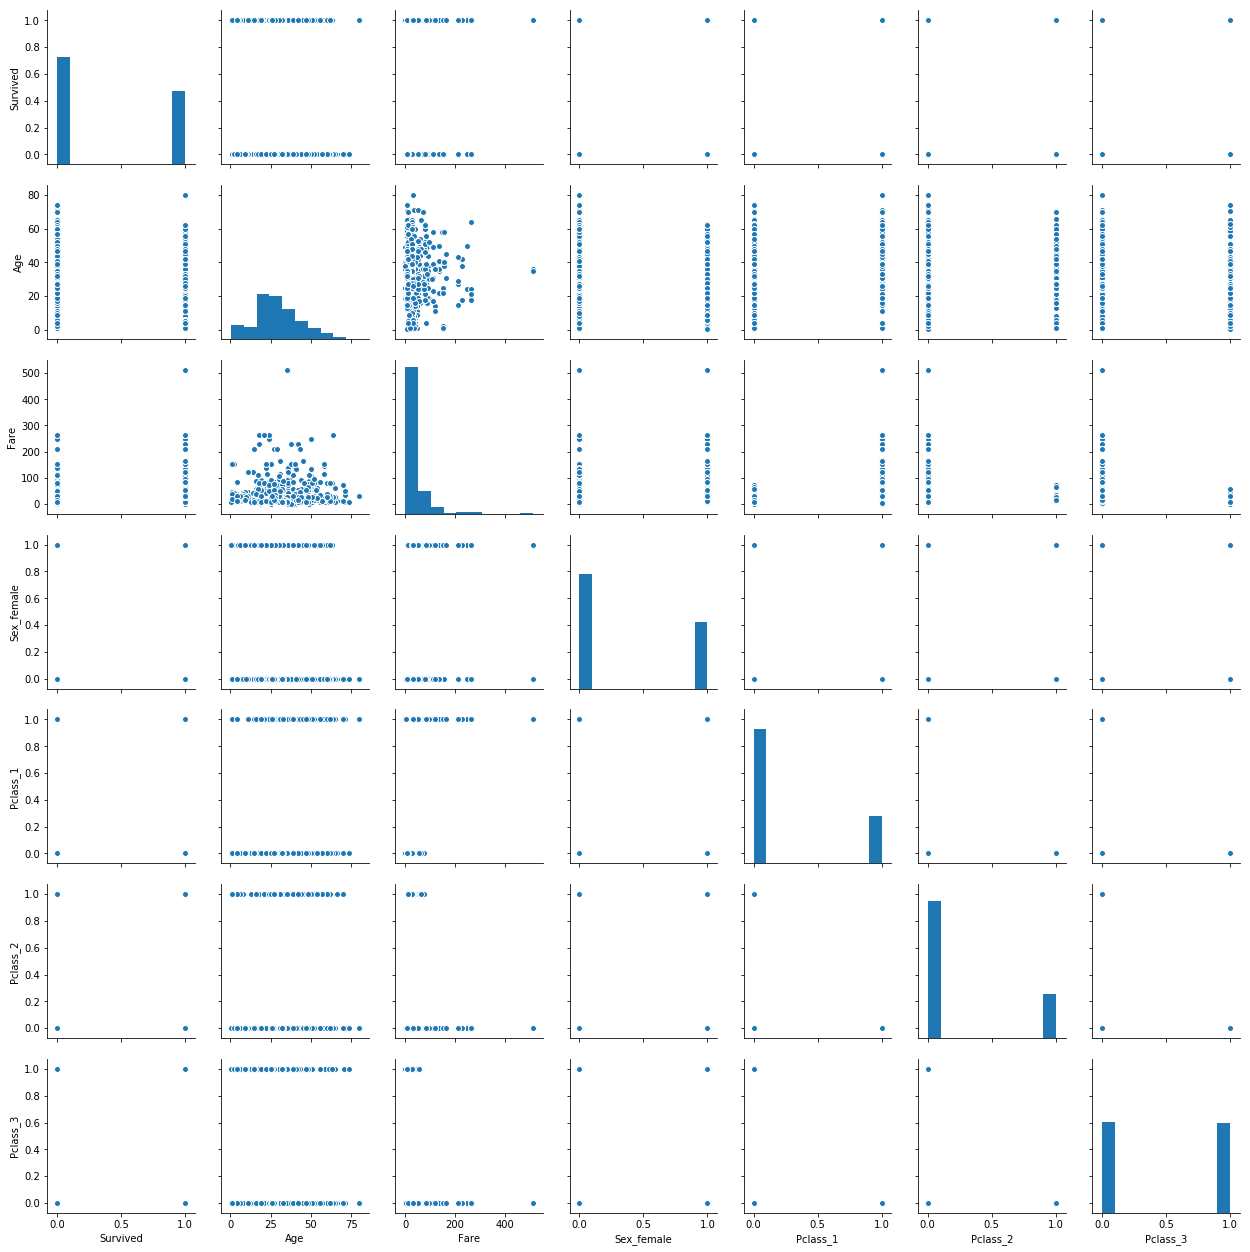

In [7]:
df_main = df[['Survived', 'Age', 'Fare', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3']].dropna()
sns.pairplot(df_main)


In [8]:
df_zeros = df.copy()
df_zeros['Age'] = df_zeros['Age'].fillna(0)
df_mean = df.copy()
df_mean['Age'] = df_mean['Age'].fillna(df_mean['Age'].mean())

In [9]:
y = df_zeros['Survived'].to_numpy()

df_zeros = df_zeros.drop('Survived', 1)
df_mean = df_mean.drop('Survived', 1)

X_real_zeros = df_zeros[real_features].to_numpy()
X_real_mean = df_mean[real_features].to_numpy()
X_cat_zeros = df_zeros[cat_features].to_numpy()
X_cat_mean = df_mean[cat_features].to_numpy()

print ("X_real: {} ".format(X_real_zeros[0]))
print ("X_cat: {} ".format(X_cat_zeros[0]))
print ("y: {} ".format(y[0]))

X_real: [22.    7.25] 
X_cat: [0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0] 
y: 0 


In [10]:
from sklearn.preprocessing import StandardScaler

scaler_zeros = StandardScaler()
X_real_zeros_scaled = scaler_zeros.fit_transform(X_real_zeros)
scaler_mean = StandardScaler()
X_real_mean_scaled = scaler_mean.fit_transform(X_real_mean)

In [11]:
print (X_real_zeros_scaled.shape)
print (X_cat_zeros.shape)
print (y.shape)

(891, 2)
(891, 22)
(891,)


In [12]:
(X_train_real_zeros, X_test_real_zeros, X_train_cat_zeros, X_test_cat_zeros, 
 y_train, y_test)= train_test_split(X_real_zeros_scaled, X_cat_zeros, y, test_size=0.3, random_state=0)
print (X_train_real_zeros.shape, X_test_real_zeros.shape)
print (X_train_cat_zeros.shape, X_test_cat_zeros.shape)

(X_train_real_mean, X_test_real_mean, X_train_cat_mean, X_test_cat_mean) = train_test_split(X_real_mean_scaled, X_cat_mean, test_size=0.3, random_state=0)
print (X_train_real_mean.shape, X_test_real_mean.shape)
print (X_train_cat_mean.shape, X_test_cat_mean.shape)

print (y_train.shape, y_test.shape)

(623, 2) (268, 2)
(623, 22) (268, 22)
(623, 2) (268, 2)
(623, 22) (268, 22)
(623,) (268,)


In [13]:
X_train_zeros = np.hstack((X_train_real_zeros, X_train_cat_zeros))
X_train_mean = np.hstack((X_train_real_mean, X_train_cat_mean))

X_test_zeros = np.hstack((X_test_real_zeros, X_test_cat_zeros))
X_test_mean = np.hstack((X_test_real_mean, X_test_cat_mean))

## Logistic regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

/Users/aleksey/anaconda3/envs/learning/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [15]:
def plot_scores(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()

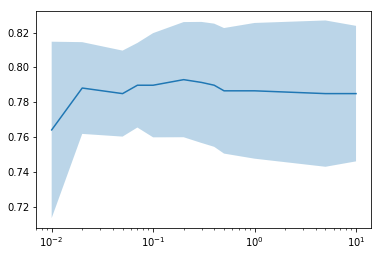

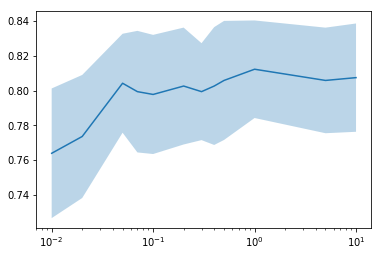

auc1: 0.8527380952380953 auc2: 0.8520833333333333


In [16]:
param_grid = {'C': [0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 5, 10]}
cv = 5

estimator = LogisticRegression('l2')

optimizer_zeros = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_zeros.fit(X_train_zeros, y_train)
plot_scores(optimizer_zeros)

predicted_zeros = optimizer_zeros.predict_proba(X_test_zeros)
auc1 = roc_auc_score(y_test, predicted_zeros[:,1])

optimizer_mean = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_mean.fit(X_train_mean, y_train)
plot_scores(optimizer_mean)

predicted_mean = optimizer_mean.predict_proba(X_test_mean)
auc2 = roc_auc_score(y_test, predicted_mean[:,1])

print("auc1: {} auc2: {}".format(auc1, auc2))

### Balancing classes

In [17]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))

381
242


In [18]:
X_train = X_train_zeros
X_test = X_test_zeros

X_train: (623, 24) y_train: (623, 1)
X_train_add: (139, 24) y_train_add: (139, 1)
X_train_added: (762, 24) y_train_added: (762,)


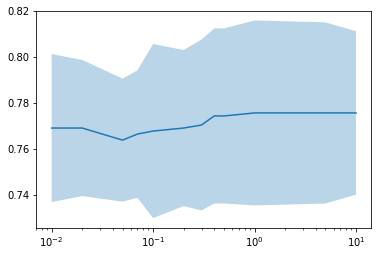

auc2: 0.8527380952380953 


In [19]:
np.random.seed(0)
y_1 = y_train[y_train==1]
y_0 = y_train[y_train==0]
indices_to_add = np.random.randint(y_1.size, size = y_0.size - y_1.size) 

X_train_to_add = X_train[y_train == 1,:][indices_to_add,:]
y_train_to_add = np.ones(X_train_to_add.shape[0])
print ("X_train: {} y_train: {}".format(X_train.shape, y_train.reshape(-1, 1).shape))
print ("X_train_add: {} y_train_add: {}".format(X_train_to_add.shape, y_train_to_add.reshape(-1, 1).shape))

X_train_added = np.vstack((X_train, X_train_to_add))
y_train_added = np.vstack((y_train.reshape(-1, 1), y_train_to_add.reshape(-1, 1))).reshape(-1)
print ("X_train_added: {} y_train_added: {}".format(X_train_added.shape, y_train_added.shape))

estimator = LogisticRegression('l2')

optimizer = GridSearchCV(estimator, param_grid, cv=cv)
optimizer.fit(X_train_added, y_train_added)
plot_scores(optimizer)

predicted = optimizer.predict_proba(X_test)
auc2 = roc_auc_score(y_test, predicted[:,1])

print("auc2: {} ".format(auc2))

### Selecting features with Lasso

X_train: (623, 24) X_test: (268, 24)


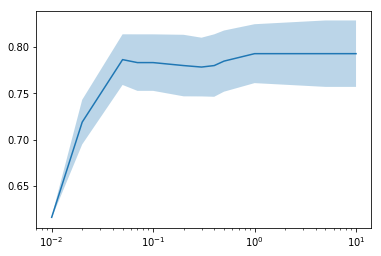

[[-0.26998855  0.18436973 -0.24995333  0.          0.          0.29017005
   0.         -0.70200734  0.          0.93249644 -0.0320982   0.
   0.74903424  0.          0.48730869  0.          0.1861887   0.16410231
  -1.6211723  -0.01401809  0.         -1.23208303  0.63111239  0.        ]]
[]
auc: 0.8496028243601059 


In [41]:
(X_train_real_zeros,  X_test_real_zeros, y_train, y_test) = train_test_split(X_real_zeros, y, test_size=0.3, random_state=0, stratify=y)
(X_train_cat_zeros, X_test_cat_zeros) = train_test_split(X_cat_zeros, test_size=0.3, random_state=0, stratify=y)

scaler = StandardScaler()
X_train_real_zeros_scaled = scaler.fit_transform(X_train_real_zeros)
X_test_real_zeros_scaled = scaler.fit_transform(X_test_real_zeros)

X_train = np.hstack((X_train_real_zeros_scaled, X_train_cat_zeros))
X_test = np.hstack((X_test_real_zeros_scaled, X_test_cat_zeros))

estimator = LogisticRegression('l1', C=10.0)

print ("X_train: {} X_test: {}".format(X_train.shape, X_test.shape))


optimizer = GridSearchCV(estimator, param_grid, cv=cv)
optimizer.fit(X_train, y_train)
plot_scores(optimizer)

print (optimizer.best_estimator_.coef_)

c = 0
null_idx = []
for cf in optimizer_zeros.best_estimator_.coef_[0][:24]:
    if cf == 0:
        null_idx.append(c)
    c += 1
print (null_idx)    



predicted_zeros = optimizer_zeros.predict_proba(X_test)
auc = roc_auc_score(y_test, predicted_zeros[:,1])

print("auc: {} ".format(auc))

In [42]:
selected_features = (0, 1, 2, 5, 7, 9, 10, 12, 14, 16, 17, 18, 19, 21, 22)

X_train_selected: (762, 15) y_train_selected: (762,)


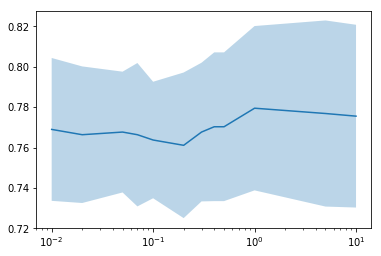

auc2: 0.8523095027949397 


In [46]:
X_train_selected = X_train_added[:,selected_features]
X_test_selected = X_test[:,selected_features]
print ("X_train_selected: {} y_train_selected: {}".format(X_train_selected.shape, y_train_added.shape))

estimator = LogisticRegression('l2')

optimizer = GridSearchCV(estimator, param_grid, cv=cv)
optimizer.fit(X_train_selected, y_train_added)
plot_scores(optimizer)

predicted = optimizer.predict_proba(X_test_selected)
auc2 = roc_auc_score(y_test, predicted[:,1])

print("auc2: {} ".format(auc2))

### LR submission

In [109]:
df = pd.read_csv('./test.csv')
passenger_ids = df['PassengerId'].to_numpy()
df = df.drop('PassengerId', 1)
df = df.drop('Name', 1)
df = df.drop('Ticket', 1)
df = df.drop('Cabin', 1)
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [110]:
encode_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
for enc in encode_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embarked_C,Embarked_Q,Embarked_S
0,34.5,7.8292,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,47.0,7.0000,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,62.0,9.6875,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,27.0,8.6625,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,22.0,12.2875,0,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [111]:
df.describe()

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embarked_C,Embarked_Q,Embarked_S
count,332.000000,417.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,...,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,30.272590,35.627188,0.255981,0.222488,0.521531,0.363636,0.636364,0.677033,0.263158,0.033493,...,0.124402,0.078947,0.007177,0.004785,0.002392,0.002392,0.004785,0.244019,0.110048,0.645933
std,14.181209,55.907576,0.436934,0.416416,0.500135,0.481622,0.481622,0.468170,0.440875,0.180135,...,0.330435,0.269980,0.084514,0.069088,0.048912,0.048912,0.069088,0.430019,0.313324,0.478803
min,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,39.000000,31.500000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,76.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [112]:
df['Age'] = df['Age'].fillna(0)
df['Fare'] = df['Fare'].fillna(0)

In [113]:
X_testing_real_zeros = df[real_features].to_numpy()
X_testing_cat_zeros = df[cat_features].to_numpy()

X_testing_real_zeros_scaled = scaler_zeros.transform(X_testing_real_zeros)

print ("X_real: {} ".format(X_real_zeros[0]))
print ("X_cat: {} ".format(X_cat_zeros[0]))
print ("y: {} ".format(y[0]))

X_real: [34.5     7.8292] 
X_cat: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0] 
y: 0 


In [114]:
print (df.shape)

(418, 25)


In [115]:
X_testing = np.hstack((X_testing_real_zeros_scaled, X_testing_cat_zeros))
X_testing = X_testing[:,selected_features]

predicted = optimizer.predict(X_testing)
print (predicted)
print (passenger_ids)

[0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.

In [116]:
with open("submission_lr.txt", "w") as fout:
    fout.write("PassengerId,Survived\n")
    for val in zip(passenger_ids, predicted):
        fout.write("{},{}\n".format(str(int(val[0])), str(int(val[1]))))